# Lab 4: Data Imputation using an Autoencoder


In this lab, you will build and train an autoencoder to impute (or "fill in") missing data.

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features.

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


In [ ]:
%%shell
jupyter nbconvert --to html "/content/Lab4_Data_Imputation.ipynb"

[NbConvertApp] Converting notebook /content/Lab4_Data_Imputation.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 574663 bytes to /content/Lab4_Data_Imputation.html


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://drive.google.com/file/d/1Y0rD0O8Qn_WKGCePSD8DZ4RuawkjAQFa/view?usp=sharing

In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data

## Part 0

We will be using a package called `pandas` for this assignment.

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here:
https://pandas.pydata.org/pandas-docs/stable/install.html

In [ ]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

<ipython-input-169-037957db2593>:3: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  df = pd.read_csv(


In [ ]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset.

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`.

Like numpy arrays and torch tensors,
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names,
for example `df["race"]`, `df["hr"]`, or even index multiple columns
like below.

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1`

would increment everyone's age by 1.

In [ ]:
columns = ["age", "yredu", "capgain", "caploss", "workhr"]
for i in columns:
  print(f"The max value in category {i} is {df[i].max()}")
  print(f"The min value in category {i} is {df[i].min()}")
  print(f"The average value in category {i} is {np.sum(df[i])/df[i].shape}")

The max value in category age is 90
The min value in category age is 17
The average value in category age is [38.58164676]
The max value in category yredu is 16
The min value in category yredu is 1
The average value in category yredu is [10.08067934]
The max value in category capgain is 99999
The min value in category capgain is 0
The average value in category capgain is [1077.64884371]
The max value in category caploss is 4356
The min value in category caploss is 0
The average value in category caploss is [87.30382973]
The max value in category workhr is 99
The min value in category workhr is 1
The average value in category workhr is [40.43745585]


In [ ]:
for i in columns: #normalize
  df[i] = (df[i] - df[i].min()) / (df[i].max() - df[i].min())


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [ ]:
# hint: you can do something like this in pandas
total_male=sum(df["sex"] == " Male")
total_people=len(df)
print(f"The percentage of people in the data set that are male is {total_male/total_people*100}%")

The percentage of people in the data set that are male is 66.92054912318419%


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [ ]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [ ]:
print(f"The number of records which contained missing features was {len(df_with_missing)}")
print(f"The percentage of records that were removed was {len(df_with_missing)/len(df)*100}%")

The number of records which contained missing features was 1843
The percentage of records that were removed was 5.660145572924664%


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [ ]:
x=set(df_not_missing["work"])
print(x)

{' Self-emp-not-inc', ' Self-emp-inc', ' Federal-gov', ' Without-pay', ' State-gov', ' Private', ' Local-gov'}


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`.

In [ ]:
data = pd.get_dummies(df_not_missing)

In [ ]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,...,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
1,0.452055,0.800000,0.00000,0.0,0.122449,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,True
2,0.287671,0.533333,0.00000,0.0,0.397959,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,True


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [ ]:
print(f"There are {data.shape[1]} columns in the dataframe data.")

There are 57 columns in the dataframe data.


The number comes from the continous and categorical features from df_not_missing, where unique values in categorical features become a seperate column.

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not
actually be "one-hot" -- the input may instead
contain real-valued predictions from our neural network.

In [ ]:
datanp = data.values.astype(np.float32)

In [ ]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.

    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.

    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`

    Examples:

    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values`
    # (created above) useful.
    max_index = np.argmax(onehot)
    return cat_values[feature][max_index]

In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
from sklearn.model_selection import train_test_split
train_data, valtest_data = train_test_split(data, test_size=0.30, random_state=50)
val_data, test_data = train_test_split(valtest_data, test_size=0.50, random_state=50)

print(f"The number of items in the training set is {train_data.shape[0]}")
print(f"The number of items in the validation set is {val_data.shape[0]}")
print(f"The number of items in the test set is {test_data.shape[0]}")



The number of items in the training set is 21502
The number of items in the validation set is 4608
The number of items in the test set is 4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information
about ~11 features.

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 256), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,20),
            nn.ReLU(),
            nn.Linear(20,11)
        )
        self.decoder = nn.Sequential(
            nn.Linear(11, 20),
            nn.ReLU(),
            nn.Linear(20, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 57), # TODO -- FILL OUT THE CODE HERE!
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

The sigmoid actuvation is the last step of the decoder to normalize the output data. Since the values inside data are one-hot encoded, the activation will ensure that the outputs match the normalized values of the inputs.

## Part 3. Training [18]

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    #
    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []
    #

    for epoch in range(num_epochs):
      #
        model.train()
        running_loss = 0.0
      #
        for data in train_loader:
            if isinstance(data, (list,tuple)):
              data = data[0]
            else:
              data = data
            data = data.to(torch.float32)
            datam = zero_out_random_feature(data.clone())
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            #
            running_loss+=loss.item()
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        train_data_tensors = [batch[0] if isinstance(batch, (list, tuple)) else batch for batch in train_loader]
        valid_data_tensors = [batch[0] if isinstance(batch, (list, tuple)) else batch for batch in valid_loader]

        train_acc = get_accuracy(model, train_data_tensors)
        val_acc = get_accuracy(model, valid_data_tensors)
        train_accuracy.append(train_acc)
        val_accuracy.append(val_acc)


        model.eval()
        valid_loss = 0.0

        with torch.no_grad():
            for data_batch in valid_loader:
                if isinstance(data_batch, (list, tuple)):
                    data = data_batch[0]
                else:
                    data = data_batch
                data = data.to(torch.float32)
                datam = zero_out_random_feature(data.clone())

                recon = model(datam)
                loss = criterion(recon, data)
                valid_loss += loss.item()

        avg_valid_loss = valid_loss / len(valid_loader)
        val_losses.append(avg_valid_loss)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {avg_train_loss:.6f}, Validation Loss: {avg_valid_loss:.6f}, Train Acc: {train_acc:.4f}, Valid Acc: {val_acc:.4f}")

        checkpoint_path="autoencoder.pth"
        torch.save(model.state_dict(), checkpoint_path)
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label="Training Accuracy")
    plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.show()
    #


### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature,
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the
    record. The returned "accuracy" measure is the percentage of times
    that our model is successful.

    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

train_data = train_data.to_numpy(dtype=np.float32) #fixing the data to all by NumPy arrays
val_data = val_data.to_numpy(dtype=np.float32)
test_data = test_data.to_numpy(dtype=np.float32)


train_tensor = torch.tensor(train_data) #making sure the arrays are now tensors
val_tensor = torch.tensor(val_data)
test_tensor = torch.tensor(test_data)

train_dataset = TensorDataset(train_tensor)
val_dataset = TensorDataset(val_tensor)
test_dataset = TensorDataset(test_tensor)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)




Epoch [1/20] - Training Loss: 0.220255, Validation Loss: 0.184714, Train Acc: 0.3486, Valid Acc: 0.3503
Epoch [2/20] - Training Loss: 0.106523, Validation Loss: 0.072530, Train Acc: 0.4595, Valid Acc: 0.4550
Epoch [3/20] - Training Loss: 0.071389, Validation Loss: 0.071200, Train Acc: 0.4599, Valid Acc: 0.4542
Epoch [4/20] - Training Loss: 0.070627, Validation Loss: 0.070643, Train Acc: 0.4605, Valid Acc: 0.4558
Epoch [5/20] - Training Loss: 0.069919, Validation Loss: 0.069702, Train Acc: 0.4595, Valid Acc: 0.4562
Epoch [6/20] - Training Loss: 0.068457, Validation Loss: 0.067278, Train Acc: 0.4617, Valid Acc: 0.4559
Epoch [7/20] - Training Loss: 0.064401, Validation Loss: 0.061397, Train Acc: 0.5102, Valid Acc: 0.5042
Epoch [8/20] - Training Loss: 0.058179, Validation Loss: 0.057075, Train Acc: 0.5375, Valid Acc: 0.5315
Epoch [9/20] - Training Loss: 0.055622, Validation Loss: 0.055469, Train Acc: 0.5558, Valid Acc: 0.5526
Epoch [10/20] - Training Loss: 0.054564, Validation Loss: 0.0544

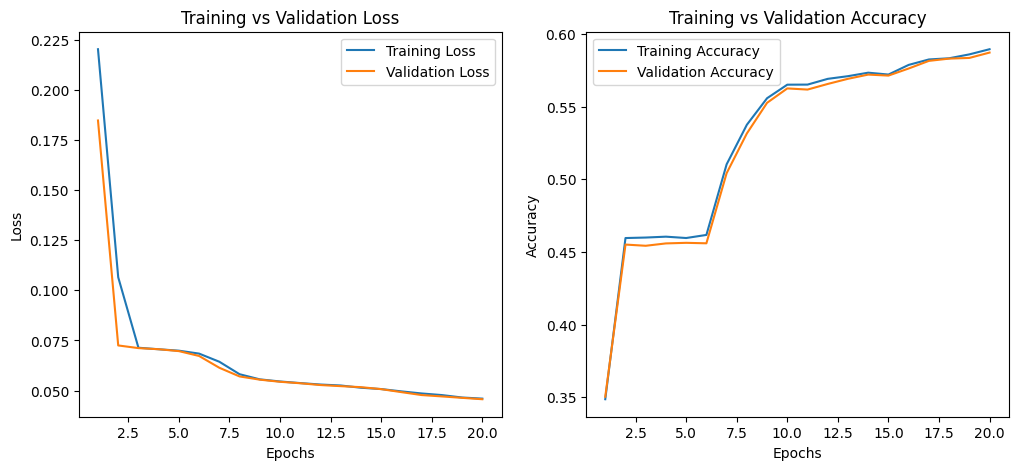

In [ ]:
autoencoder = AutoEncoder()
train(autoencoder, train_loader, valid_loader, num_epochs=20, learning_rate=1e-4)


### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you
chose the next set of hyperparameters to try.

Epoch [1/50] - Training Loss: 0.118994, Validation Loss: 0.070696, Train Acc: 0.4595, Valid Acc: 0.4562
Epoch [2/50] - Training Loss: 0.067766, Validation Loss: 0.060377, Train Acc: 0.5159, Valid Acc: 0.5110
Epoch [3/50] - Training Loss: 0.055404, Validation Loss: 0.054244, Train Acc: 0.5657, Valid Acc: 0.5632
Epoch [4/50] - Training Loss: 0.052860, Validation Loss: 0.052536, Train Acc: 0.5706, Valid Acc: 0.5666
Epoch [5/50] - Training Loss: 0.051273, Validation Loss: 0.050656, Train Acc: 0.5799, Valid Acc: 0.5790
Epoch [6/50] - Training Loss: 0.049708, Validation Loss: 0.049318, Train Acc: 0.5804, Valid Acc: 0.5821
Epoch [7/50] - Training Loss: 0.048206, Validation Loss: 0.047562, Train Acc: 0.5814, Valid Acc: 0.5800
Epoch [8/50] - Training Loss: 0.045645, Validation Loss: 0.044791, Train Acc: 0.5868, Valid Acc: 0.5844
Epoch [9/50] - Training Loss: 0.043340, Validation Loss: 0.042580, Train Acc: 0.5883, Valid Acc: 0.5828
Epoch [10/50] - Training Loss: 0.041832, Validation Loss: 0.0413

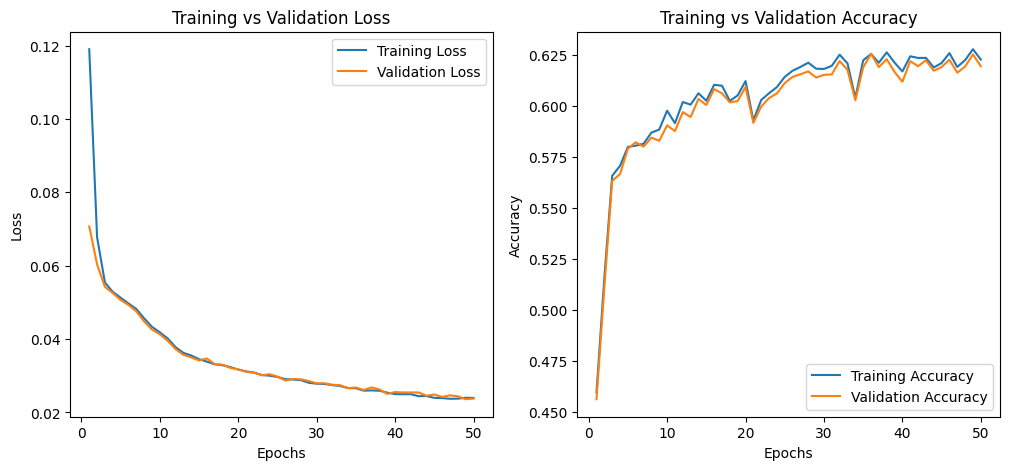

In [ ]:
train_tensor = torch.tensor(train_data)
val_tensor = torch.tensor(val_data)
test_tensor = torch.tensor(test_data)

train_dataset = TensorDataset(train_tensor)
val_dataset = TensorDataset(val_tensor)
test_dataset = TensorDataset(test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
autoencoder = AutoEncoder()
train(autoencoder, train_loader, valid_loader, num_epochs=50, learning_rate=1e-4)

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [ ]:
test_data_tensors = [batch[0] if isinstance(batch, (list, tuple)) else batch for batch in test_loader]

test_accuracy = get_accuracy(autoencoder, test_data_tensors)

print(f"Final Test Accuracy: {test_accuracy:.4f}")


Final Test Accuracy: 0.6228


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set.

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [ ]:
train_df = pd.DataFrame(train_data, columns=data.columns)

baseline_predictions = {}

for feature in catcols:
    one_hot_columns = [col for col in train_df.columns if col.startswith(feature + "_")]

    if one_hot_columns:
        most_common_one_hot = train_df[one_hot_columns].sum().idxmax()  # most common value of the feature in the training set.
        most_common_category = most_common_one_hot[len(feature) + 1:]  # category

        baseline_predictions[feature] = most_common_category

def baseline(test_df, baseline_predictions):
    """Compute baseline accuracy by predicting the most common category in the training set."""
    correct = 0
    total = 0

    for feature in catcols:
        one_hot_columns = [col for col in test_df.columns if col.startswith(feature + "_")]

        if one_hot_columns:
            for i in range(len(test_df)):
                true_values = test_df.iloc[i][one_hot_columns]
                true_category = one_hot_columns[np.argmax(true_values)]  # find the respective category
                true_category = true_category[len(feature) + 1:]

                predicted_category = baseline_predictions[feature]

                if true_category == predicted_category:
                    correct += 1

                total += 1

    return correct / total

test_df = pd.DataFrame(test_data, columns=data.columns)

baseline_accuracy = baseline(test_df, baseline_predictions)
print(f"Baseline Model Test Accuracy: {baseline_accuracy:.4f}")




Baseline Model Test Accuracy: 0.4584


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

The test accuracy from part (a) is better than the baseline test accuracy from part (b).

### Part (d) [1 pt]

Look at the first item in your test data.
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

I don't think it's reasonable for a human to guess this person's education level based off of their other features because their administrative clerical job does not necessarily suggest  bachelors degree.

In [ ]:
data.iloc[0]

,0
age,0.30137
yredu,0.8
capgain,0.02174
caploss,0.0
workhr,0.397959
work_ Federal-gov,False
work_ Local-gov,False
work_ Private,False
work_ Self-emp-inc,False
work_ Self-emp-not-inc,False


### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [ ]:


def predict_education(model, input_features):
    """
    Predicts the education level for a given person using the trained autoencoder.
    """
    model.eval()
    input_tensor = torch.tensor(input_features, dtype=torch.float32).unsqueeze(0)  # create the input tensor
    input_tensor = zero_out_feature(input_tensor.clone(), "edu")  # Set "edu" feature to missing

    reconstructed = model(input_tensor).detach().numpy()

    predicted_edu_onehot = get_onehot(reconstructed[0], "edu")#make sure to get the education feature
    predicted_education = get_categorical_value(predicted_edu_onehot, "edu")

    return predicted_education

input_features = test_data[0]  #the first item in test data
autoencoder = AutoEncoder()

predicted_edu = predict_education(autoencoder, input_features)

print(f"Predicted Education Level: {predicted_edu}")


Predicted Education Level: Doctorate


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [ ]:

train_df = pd.DataFrame(train_data, columns=data.columns)

edu_columns = [col for col in train_df.columns if col.startswith("edu_")]#each education column

most_common_edu = train_df[edu_columns].sum().idxmax()
most_common_edu= most_common_edu[len("edu_"):]

print(f"Baseline Model Prediction for Education Level: {most_common_edu}")


Baseline Model Prediction for Education Level:  HS-grad
